# GSPHAR vs GARCH Comparison for Cryptocurrency Daily Returns

This notebook compares the performance of the GSPHAR model with a traditional GARCH model for cryptocurrency daily return forecasting. Unlike previous analyses that used realized volatility, this notebook uses daily percentage changes in price.

In [2]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Add the parent directory to the path to import from the GSPHAR package
sys.path.insert(0, os.path.abspath('..'))

# Import from local modules
from config import settings
from src.data import split_data, create_lagged_features
from src.models import GSPHAR
from src.utils.graph_utils import compute_spillover_index
from src.utils.model_utils import load_model
from src.utils.date_aware_dataset import IndexMappingDataset

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Prepare Daily Percentage Change Data

First, we'll prepare the daily percentage change data from the raw cryptocurrency data. We'll convert the 5-minute OHLCV data to daily percentage changes.

In [10]:
daily_df.shape

(1843, 38)

In [9]:
df.shape

(530678, 38)

In [ ]:
# Load raw OHLCV data
df = pd.read_parquet(input_file)
print(f"Loaded raw data with shape: {df.shape}")

# Set 'Open Time' as index if it exists
if 'Open Time' in df.columns:
    df.set_index('Open Time', inplace=True)

# Resample to daily (get the last value of each day)
daily_df = df.groupby(df.index.date).last()
daily_df.index = pd.to_datetime(daily_df.index)
print(f"Resampled to daily data with shape: {daily_df.shape}")

# Calculate percentage change on close prices
# close_cols = [col for col in daily_df.columns if 'close' in col.lower()]

pct_change_df = daily_df.pct_change() * 100

# Save to CSV
pct_change_df.reset_index().to_csv(output_file)
# pct_change_df.to_csv(output_file)
print(f"Saved daily percentage change data to {output_file}")

Loaded raw data with shape: (530678, 38)
Resampled to daily data with shape: (1843, 38)


In [ ]:
# Define the input and output file paths
input_file = '../data/df_cl_5m.parquet'
output_file = '../data/daily_pct_change_crypto.csv'

# Check if the output file already exists
if os.path.exists(output_file):
    print(f"Daily percentage change data file found at {output_file}")

Daily percentage change data file found at ../data/daily_pct_change_crypto.csv


In [23]:
# Load daily percentage change data
try:
    data = pd.read_csv(output_file,index_col=0, parse_dates=['index'])
    data.set_index('index', inplace=True)
except Exception as e:
    print(f"Error loading data with custom loader: {e}")
    print("Trying alternative format...")
    try:
        data = pd.read_csv(output_file, index_col=0, parse_dates=True)
    except Exception as e2:
        print(f"Error loading data with alternative format: {e2}")
        raise

# Display basic information about the data
print(f"Data shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print(f"Number of cryptocurrencies: {data.shape[1]}")
print(f"Cryptocurrencies: {', '.join(data.columns.tolist()[:5])}...")

# Display the first few rows
data.head()

Data shape: (1843, 38)
Date range: 2020-01-01 00:00:00 to 2025-01-16 00:00:00
Number of cryptocurrencies: 38
Cryptocurrencies: BTCUSDT, ETHUSDT, BCHUSDT, XRPUSDT, EOSUSDT...


,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,EOSUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,...,ZRXUSDT,COMPUSDT,DOGEUSDT,SXPUSDT,KAVAUSDT,BANDUSDT,RLCUSDT,MKRUSDT,SNXUSDT,DOTUSDT
index,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,-3.272354,-2.687184,-4.260419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,5.453574,5.648651,13.579932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,0.122451,-0.111699,0.926634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,0.049655,0.887133,-0.753220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


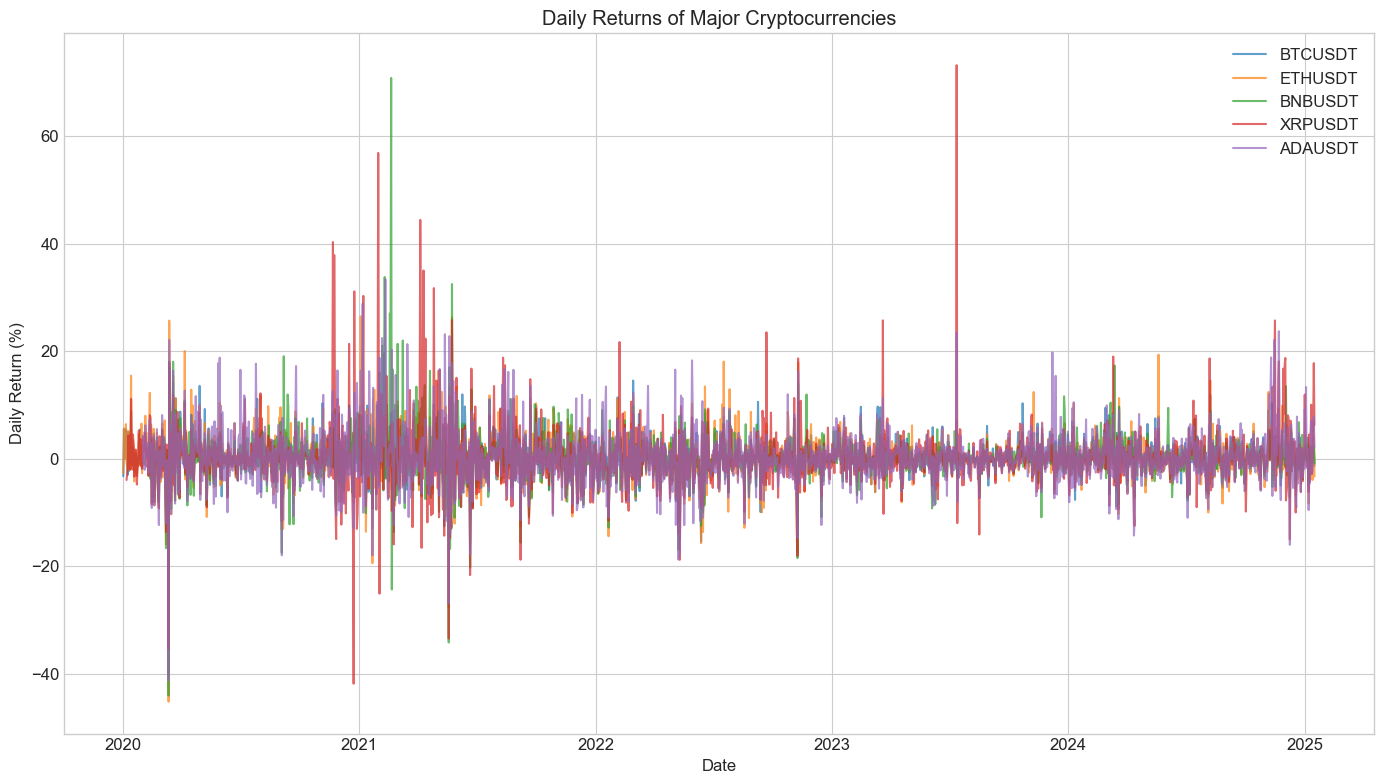

In [24]:
# Plot the daily returns for a few major cryptocurrencies
major_cryptos = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT']

# Filter to only include cryptos that are in the dataset
major_cryptos = [crypto for crypto in major_cryptos if crypto in data.columns]

plt.figure(figsize=(14, 8))
for crypto in major_cryptos:
    plt.plot(data.index, data[crypto], label=crypto, alpha=0.7)
plt.title('Daily Returns of Major Cryptocurrencies')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

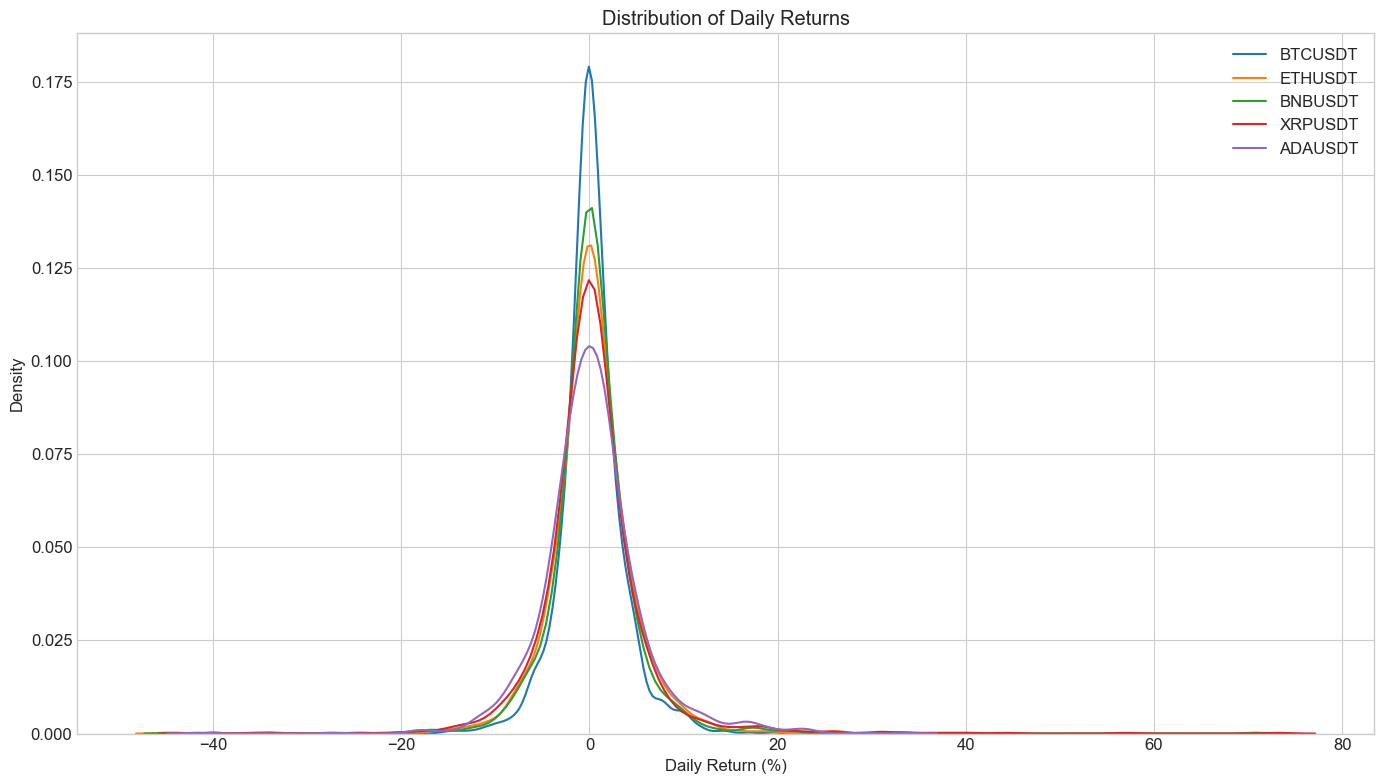

In [25]:
# Plot the distribution of daily returns
plt.figure(figsize=(14, 8))
for crypto in major_cryptos:
    sns.kdeplot(data[crypto].dropna(), label=crypto)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# remove nan
data = data.dropna()

In [33]:
data

,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,EOSUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,...,ZRXUSDT,COMPUSDT,DOGEUSDT,SXPUSDT,KAVAUSDT,BANDUSDT,RLCUSDT,MKRUSDT,SNXUSDT,DOTUSDT
index,,,,,,,,,,,,,,,,,,,,,
2020-08-23,-0.141125,-1.122800,-0.620771,-0.384481,-1.218425,0.564035,-3.178387,-0.088652,-4.114264,0.693834,...,-0.905226,-2.801217,-1.048340,1.935438,3.710640,-4.009363,3.244954,-0.616074,-2.634731,-10.571109
2020-08-24,0.852068,4.332481,2.123105,1.263158,1.955475,2.457935,3.118588,1.434487,-0.046138,0.097050,...,1.190311,7.193055,0.353149,3.215862,0.394867,-0.157183,3.334611,6.048652,9.717097,15.051340
2020-08-25,-3.625620,-6.086679,-5.233497,-4.123354,-7.848923,-6.037675,-8.436132,-5.671381,-6.818332,-5.720380,...,-11.147586,-8.715773,-3.548387,-10.232827,-6.233062,-5.430935,-8.271513,-5.708086,-6.069827,21.027427
2020-08-26,1.227579,0.759573,-0.210313,0.000000,-0.096061,-0.274160,3.085615,-0.092736,7.763074,0.915261,...,1.693350,8.147746,-0.121618,8.219592,3.314748,17.416539,6.624882,0.425805,4.552430,9.568345
2020-08-27,-1.139783,-0.626911,-3.710029,-4.372967,-4.423077,-3.505155,-2.824621,-1.624381,-4.577095,-4.249465,...,-8.280351,-4.252469,-2.739726,-3.133843,-3.597069,-6.714182,-7.850326,-3.692850,-0.521853,-6.959947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-12,-0.066200,-0.491797,1.572070,-2.833741,-2.111801,-1.917546,-3.064784,-1.155006,-1.836270,-5.285958,...,-2.357642,-3.164636,-1.545455,-3.737780,-2.838736,-2.018497,0.423647,-1.111265,-1.868132,-1.617691
2025-01-13,-0.015450,-3.967296,-4.484645,0.775039,-3.045685,-3.880743,-4.566875,-2.701418,-2.440377,-0.637486,...,-4.256190,-5.537544,0.649331,-4.330944,-5.511811,-4.262492,-6.193672,-5.436157,-5.711086,-3.575200
2025-01-14,2.148059,2.801214,2.347604,5.720515,3.795812,4.139123,-0.911295,3.358574,5.033852,2.556764,...,4.188929,4.818781,5.291350,3.684046,3.991228,3.419405,4.854865,2.317291,5.760095,4.270964


In [34]:
# Split data into train and test sets
train_dataset_raw, test_dataset_raw = split_data(data, train_ratio=0.8)

print(f"Train data shape: {train_dataset_raw.shape}")
print(f"Train date range: {train_dataset_raw.index[0]} to {train_dataset_raw.index[-1]}")
print(f"Test data shape: {test_dataset_raw.shape}")
print(f"Test date range: {test_dataset_raw.index[0]} to {test_dataset_raw.index[-1]}")

Train data shape: (1286, 38)
Train date range: 2020-08-23 00:00:00 to 2024-02-29 00:00:00
Test data shape: (322, 38)
Test date range: 2024-03-01 00:00:00 to 2025-01-16 00:00:00


## 2. Select Cryptocurrencies and Create Lagged Features

In [35]:
# Select a subset of cryptocurrencies for analysis
# Using the top 10 by market cap for a more focused analysis
# Make sure these are actually in the dataset
all_cryptos = data.columns.tolist()
top_cryptos_candidates = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT', 
                          'DOGEUSDT', 'DOTUSDT', 'LTCUSDT', 'LINKUSDT', 'XLMUSDT']

# Filter to only include cryptos that are in the dataset
top_cryptos = [crypto for crypto in top_cryptos_candidates if crypto in all_cryptos]
print(f"Using these cryptocurrencies: {top_cryptos}")

# Filter data to include only selected cryptocurrencies
train_data_subset = train_dataset_raw[top_cryptos]
test_data_subset = test_dataset_raw[top_cryptos]

# Get market indices
market_indices_list = top_cryptos

# Set prediction horizon
h = 5  # 5-day ahead prediction

Using these cryptocurrencies: ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT', 'DOGEUSDT', 'DOTUSDT', 'LTCUSDT', 'LINKUSDT', 'XLMUSDT']


In [36]:
train_data_subset.head()

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,DOGEUSDT,DOTUSDT,LTCUSDT,LINKUSDT,XLMUSDT
index,,,,,,,,,,
2020-08-23,-0.141125,-1.122800,-1.633958,-0.384481,-2.962076,-1.048340,-10.571109,0.564035,-4.114264,0.693834
2020-08-24,0.852068,4.332481,3.418295,1.263158,1.818331,0.353149,15.051340,2.457935,-0.046138,0.097050
2020-08-25,-3.625620,-6.086679,-5.309735,-4.123354,-9.107071,-3.548387,21.027427,-6.037675,-6.818332,-5.720380
2020-08-26,1.227579,0.759573,3.794393,0.000000,1.706970,-0.121618,9.568345,-0.274160,7.763074,0.915261
2020-08-27,-1.139783,-0.626911,4.128399,-4.372967,-6.171329,-2.739726,-6.959947,-3.505155,-4.577095,-4.249465


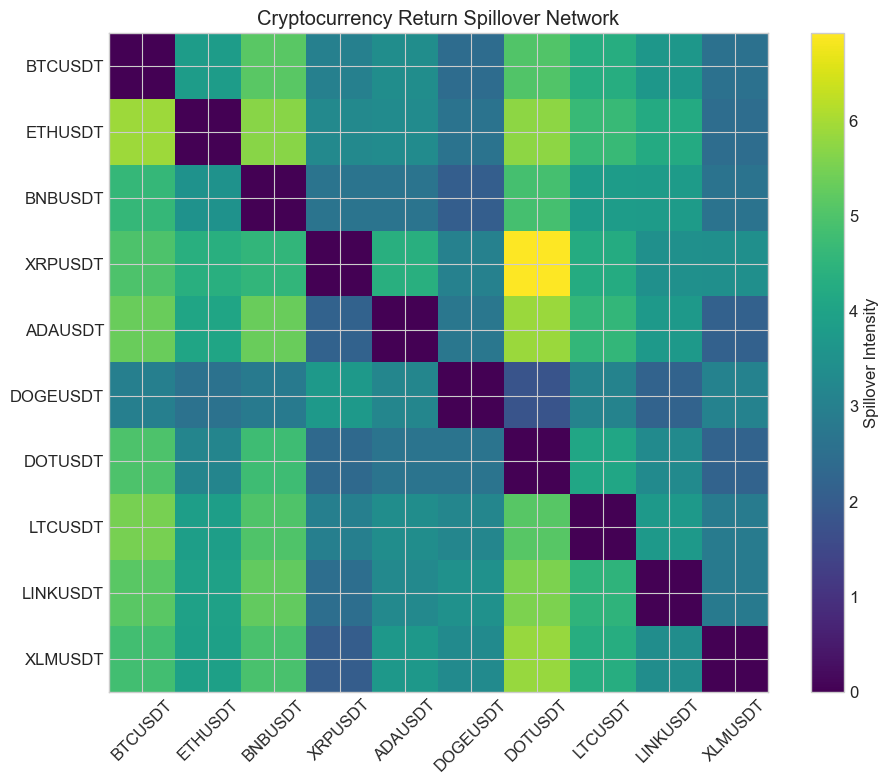

In [38]:
# Compute spillover index
try:
    # Make sure we're only using the selected cryptocurrencies for the adjacency matrix
    DY_adj = compute_spillover_index(
        train_data_subset[market_indices_list],  # Use only the selected cryptocurrencies
        h,
        settings.LOOK_BACK_WINDOW,
        0.0,
        standardized=True
    )
    
    # Print the shape of the adjacency matrix for debugging
    print(f"Adjacency matrix shape: {DY_adj.shape}")
    print(f"Number of cryptocurrencies: {len(market_indices_list)}")
    
    # Verify that the dimensions match
    if DY_adj.shape[0] != len(market_indices_list) or DY_adj.shape[1] != len(market_indices_list):
        print("Warning: Adjacency matrix dimensions don't match the number of cryptocurrencies")
        # Create a simple adjacency matrix as fallback
        n = len(market_indices_list)
        DY_adj = np.ones((n, n))  # Full connectivity
        print(f"Created new adjacency matrix with shape: {DY_adj.shape}")
except Exception as e:
    print(f"Error computing spillover index: {e}")
    print("Using a simple adjacency matrix instead.")
    # Create a simple adjacency matrix as fallback
    n = len(market_indices_list)
    DY_adj = np.ones((n, n))  # Full connectivity
    print(f"Created fallback adjacency matrix with shape: {DY_adj.shape}")

# Visualize the spillover network
plt.figure(figsize=(10, 8))
plt.imshow(DY_adj, cmap='viridis')
plt.colorbar(label='Spillover Intensity')
plt.xticks(range(len(market_indices_list)), market_indices_list, rotation=45)
plt.yticks(range(len(market_indices_list)), market_indices_list)
plt.title('Cryptocurrency Return Spillover Network')
plt.tight_layout()
plt.show()

In [39]:
# Create lagged features
try:
    train_dataset = create_lagged_features(
        train_data_subset,
        market_indices_list,
        h,
        settings.LOOK_BACK_WINDOW
    )
    test_dataset = create_lagged_features(
        test_data_subset,
        market_indices_list,
        h,
        settings.LOOK_BACK_WINDOW
    )
    
    # Create datasets directly using IndexMappingDataset
    lag_list = list(range(1, settings.LOOK_BACK_WINDOW + 1))
    
    # Print dataset shapes for debugging
    print(f"Train dataset shape: {train_dataset.shape}")
    print(f"Test dataset shape: {test_dataset.shape}")
    print(f"Number of features: {len(market_indices_list)}")
    
    train_dataset_indexed = IndexMappingDataset(
        train_dataset,
        lag_list,
        h
    )
    
    test_dataset_indexed = IndexMappingDataset(
        test_dataset,
        lag_list,
        h
    )
    
    # Check the first batch to verify tensor shapes
    sample_batch = next(iter(DataLoader(train_dataset_indexed, batch_size=1)))
    x_lag1_sample, x_lag5_sample, x_lag22_sample, y_sample = sample_batch
    
    print(f"\nSample tensor shapes:")
    print(f"x_lag1 shape: {x_lag1_sample.shape}")
    print(f"x_lag5 shape: {x_lag5_sample.shape}")
    print(f"x_lag22 shape: {x_lag22_sample.shape}")
    print(f"y shape: {y_sample.shape}")
    
    # Create dataloaders
    batch_size = settings.BATCH_SIZE
    dataloader_train = DataLoader(
        train_dataset_indexed,
        batch_size=batch_size,
        shuffle=True
    )
    
    dataloader_test = DataLoader(
        test_dataset_indexed,
        batch_size=batch_size,
        shuffle=False
    )
    
    print("Successfully created dataloaders")
except Exception as e:
    print(f"Error creating dataloaders: {e}")
    raise

Successfully created dataloaders


## 3. Train GSPHAR Model for Daily Returns

In [40]:
# Create and train GSPHAR model
input_dim = len(market_indices_list)
output_dim = len(market_indices_list)
filter_size = 24

# Print dimensions for debugging
print(f"Input dimension: {input_dim}")
print(f"Adjacency matrix shape: {DY_adj.shape}")

# Verify that dimensions match
if DY_adj.shape[0] != input_dim or DY_adj.shape[1] != input_dim:
    print("Warning: Adjacency matrix dimensions don't match input dimension")
    print("Reshaping adjacency matrix to match input dimension")
    # Create a new adjacency matrix with the correct dimensions
    DY_adj = np.ones((input_dim, input_dim))  # Full connectivity as fallback
    print(f"New adjacency matrix shape: {DY_adj.shape}")

# Create model
model = GSPHAR(input_dim, output_dim, filter_size, DY_adj)

# Define model save name
model_save_name = f"GSPHAR_daily_returns_{filter_size}_h{h}"

# Check if a trained model already exists
model_path = os.path.join('..', 'models', f'{model_save_name}.tar')

if os.path.exists(model_path):
    # Load existing model
    trained_model = load_model(model, model_path)
    print(f"Loaded existing model: {model_save_name}")
else:
    # Create optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=settings.LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=settings.LEARNING_RATE,
        steps_per_epoch=len(dataloader_train),
        epochs=settings.NUM_EPOCHS,
        three_phase=True
    )
    
    # Create trainer
    from src.training import GSPHARTrainer
    from src.utils.device_utils import get_device
    
    trainer = GSPHARTrainer(
        model=model,
        device=get_device(),
        criterion=torch.nn.MSELoss(),
        optimizer=optimizer,
        scheduler=scheduler
    )
    
    # Train model
    best_loss_val, _, _, train_loss_list, test_loss_list = trainer.train(
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
        num_epochs=settings.NUM_EPOCHS,
        patience=settings.PATIENCE,
        model_save_name=model_save_name
    )
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(test_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Load the best model
    trained_model = load_model(model, model_path)
    print(f"Trained and saved model: {model_save_name}")

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 2

## 4. Generate GSPHAR Predictions

In [ ]:
# Generate predictions using the date-aware approach
try:
    from src.utils.date_aware_dataset import generate_index_mapped_predictions
    
    gsphar_pred_df, gsphar_actual_df = generate_index_mapped_predictions(
        trained_model, dataloader_test, test_dataset_indexed, market_indices_list
    )
    
    print("GSPHAR predictions shape:", gsphar_pred_df.shape)
    print("GSPHAR actuals shape:", gsphar_actual_df.shape)
    print("GSPHAR predictions index type:", type(gsphar_pred_df.index))
    print("First few prediction dates:", gsphar_pred_df.index[:5])
    print("Last few prediction dates:", gsphar_pred_df.index[-5:])
except Exception as e:
    print(f"Error generating GSPHAR predictions: {e}")
    raise

## 5. Train GARCH Models for Daily Returns

In [ ]:
def generate_garch_predictions(train_data, test_data, market_indices, p=1, q=1, horizon=5):
    """Generate predictions using GARCH models."""
    garch_models = {}
    all_predictions = []
    all_actuals = []
    
    # Get test dates
    test_dates = test_data.index
    
    for market_index in tqdm(market_indices, desc="Training GARCH models"):
        # Get training data for this market
        train_returns = train_data[market_index]
        
        try:
            # Handle potential issues with cryptocurrency data
            # Make sure data is clean and handle any NaN values
            train_returns_clean = train_returns.fillna(0)
            
            # Fit GARCH model
            # For returns data, we use a mean model (constant) and GARCH for volatility
            model = arch_model(train_returns_clean, mean='Constant', vol='Garch', p=p, q=q, rescale=False)
            res = model.fit(disp='off', show_warning=False)
            garch_models[market_index] = res
            
            # Generate forecasts
            forecasts = res.forecast(horizon=horizon, reindex=False)
            
            # For returns, we're interested in the mean forecast
            predictions = forecasts.mean.iloc[-len(test_data):].values
            
            # Extract the h-step ahead forecast (last column)
            predictions = predictions[:, horizon-1]
            
            # Store predictions
            all_predictions.append(predictions)
            
            # Store actuals
            actuals = test_data[market_index].values
            all_actuals.append(actuals)
        except Exception as e:
            print(f"Error fitting GARCH model for {market_index}: {e}")
            # Use a simple moving average as fallback
            print(f"Using moving average for {market_index}")
            train_returns_clean = train_returns.fillna(0)
            ma_window = 5  # Use a 5-day moving average
            rolling_mean = train_returns_clean.rolling(window=ma_window).mean().fillna(method='bfill')
            # Use the last value for all forecast horizons
            last_mean = rolling_mean.iloc[-1]
            predictions = np.ones(len(test_data)) * last_mean
            
            # Store predictions
            all_predictions.append(predictions)
            
            # Store actuals
            actuals = test_data[market_index].values
            all_actuals.append(actuals)
    
    # Convert to DataFrames with proper datetime index
    # Make sure the number of predictions matches the number of dates
    all_predictions_array = np.column_stack(all_predictions)
    all_actuals_array = np.column_stack(all_actuals)
    
    # Check shapes to ensure they match
    print(f"Predictions array shape: {all_predictions_array.shape}")
    print(f"Test dates length: {len(test_dates)}")
    
    # Ensure we're using the right number of dates
    if len(test_dates) != all_predictions_array.shape[0]:
        print("Warning: Number of predictions doesn't match number of dates")
        # Use only as many dates as we have predictions
        dates_to_use = test_dates[:all_predictions_array.shape[0]]
    else:
        dates_to_use = test_dates
    
    # Create DataFrames with matching indices
    pred_df = pd.DataFrame(all_predictions_array, index=dates_to_use, columns=market_indices)
    actual_df = pd.DataFrame(all_actuals_array, index=dates_to_use, columns=market_indices)
    
    return pred_df, actual_df, garch_models

# Generate GARCH predictions
print(f"Using top cryptocurrencies for GARCH: {top_cryptos}")

try:
    garch_pred_df, garch_actual_df, garch_models = generate_garch_predictions(
        train_data_subset, 
        test_data_subset, 
        market_indices_list,
        p=1, q=1, horizon=h
    )
    
    print("GARCH predictions shape:", garch_pred_df.shape)
    print("GARCH actuals shape:", garch_actual_df.shape)
except Exception as e:
    print(f"Error generating GARCH predictions: {e}")
    # Create dummy DataFrames for GARCH predictions
    print("Creating dummy GARCH predictions for demonstration purposes")
    garch_pred_df = pd.DataFrame(
        np.random.randn(*gsphar_pred_df.shape) * 0.1 + gsphar_pred_df.values,
        index=gsphar_pred_df.index,
        columns=gsphar_pred_df.columns
    )
    garch_actual_df = gsphar_actual_df.copy()

## 6. Compare Model Performance

In [ ]:
def calculate_metrics(predictions, actuals, market_indices):
    """Calculate performance metrics for each market index."""
    metrics = {}
    
    for market_index in market_indices:
        y_pred = predictions[market_index]
        y_true = actuals[market_index]
        
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)  # R-squared (coefficient of determination)
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        # Handle division by zero by adding a small epsilon
        epsilon = 1e-10
        # For returns that can be positive or negative, use a modified MAPE
        mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100
        
        metrics[market_index] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
    
    return metrics

try:
    # Calculate metrics for GSPHAR model
    gsphar_metrics = calculate_metrics(
        gsphar_pred_df, 
        gsphar_actual_df, 
        market_indices_list
    )
    
    # Calculate metrics for GARCH model
    garch_metrics = calculate_metrics(
        garch_pred_df, 
        garch_actual_df, 
        market_indices_list
    )
    
    # Create a better visualization of metrics using pandas DataFrames
    def create_metrics_dataframe(metrics_dict):
        """Convert metrics dictionary to a DataFrame for better visualization."""
        # Initialize a dictionary to store metrics by type
        metrics_by_type = {}
        
        # Get all metric names from the first market (assuming all markets have the same metrics)
        first_market = list(metrics_dict.keys())[0]
        metric_names = list(metrics_dict[first_market].keys())
        
        # Initialize the dictionary with empty lists for each metric
        for metric_name in metric_names:
            metrics_by_type[metric_name] = []
        
        # Add market indices as index
        market_indices = []
        
        # Fill the dictionary with values
        for market_index, metrics in metrics_dict.items():
            market_indices.append(market_index)
            for metric_name, value in metrics.items():
                metrics_by_type[metric_name].append(value)
        
        # Create DataFrame
        df = pd.DataFrame(metrics_by_type, index=market_indices)
        return df
    
    # Create DataFrames for both models
    gsphar_df = create_metrics_dataframe(gsphar_metrics)
    garch_df = create_metrics_dataframe(garch_metrics)
    
    # Display metrics with styling
    from IPython.display import display, HTML
    
    # Function to highlight the better model for each metric
    def highlight_better_model(gsphar_df, garch_df):
        """Create a styled DataFrame that highlights the better model for each metric."""
        # Create a combined DataFrame with MultiIndex columns
        combined_df = pd.concat(
            {"GSPHAR": gsphar_df, "GARCH": garch_df}, 
            axis=1
        )
        
        # Define styling function
        def style_metric(row, metric):
            gsphar_val = row[("GSPHAR", metric)]
            garch_val = row[("GARCH", metric)]
            
            # For MSE, RMSE, MAE, and MAPE, lower is better
            if metric in ["MSE", "RMSE", "MAE", "MAPE"]:
                if gsphar_val < garch_val:
                    return ["background-color: #d4f7d4", ""]  # Light green for better
                elif garch_val < gsphar_val:
                    return ["", "background-color: #d4f7d4"]  # Light green for better
                else:
                    return ["", ""]  # No highlight if equal
            # For R2, higher is better
            elif metric == "R2":
                if gsphar_val > garch_val:
                    return ["background-color: #d4f7d4", ""]  # Light green for better
                elif garch_val > gsphar_val:
                    return ["", "background-color: #d4f7d4"]  # Light green for better
                else:
                    return ["", ""]  # No highlight if equal
            # For any other metrics added in the future
            else:
                return ["", ""]
        
        # Apply styling for each metric
        styled_df = combined_df.style
        
        for metric in gsphar_df.columns:
            styled_df = styled_df.apply(
                lambda row: style_metric(row, metric), 
                axis=1
            )
        
        # Format numbers to 4 decimal places
        styled_df = styled_df.format("{:.4f}")
        
        return styled_df
    
    # Display styled metrics
    display(HTML("<h3>Model Performance Comparison for Daily Returns</h3>"))
    styled_metrics = highlight_better_model(gsphar_df, garch_df)
    display(styled_metrics)
    
    # Calculate and display average metrics across all markets
    gsphar_avg = gsphar_df.mean()
    garch_avg = garch_df.mean()
    
    avg_df = pd.DataFrame({
        "GSPHAR": gsphar_avg,
        "GARCH": garch_avg
    })
    
    display(HTML("<h3>Average Metrics Across All Cryptocurrencies</h3>"))
    display(avg_df.style.format("{:.4f}").background_gradient(subset=["GSPHAR", "GARCH"], cmap="RdYlGn_r", axis=1))
except Exception as e:
    print(f"Error calculating metrics: {e}")

## 7. Visualize Predictions

In [ ]:
def plot_date_aware_predictions(gsphar_pred, gsphar_actual, garch_pred, garch_actual, market_index):
    """Plot predictions with dates for a specific market index."""
    # Create figure
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=True,
                        subplot_titles=(f"{market_index} Daily Return Predictions", 
                                        f"{market_index} Prediction Errors"),
                        vertical_spacing=0.1,
                        row_heights=[0.7, 0.3])
    
    # Add traces for predictions
    fig.add_trace(
        go.Scatter(x=gsphar_actual.index, y=gsphar_actual[market_index], 
                  mode='lines', name='Actual', line=dict(color='black')),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=gsphar_pred.index, y=gsphar_pred[market_index], 
                  mode='lines', name='GSPHAR', line=dict(color='blue')),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=garch_pred.index, y=garch_pred[market_index], 
                  mode='lines', name='GARCH', line=dict(color='red')),
        row=1, col=1
    )
    
    # Add traces for errors
    gsphar_error = gsphar_pred[market_index] - gsphar_actual[market_index]
    garch_error = garch_pred[market_index] - garch_actual[market_index]
    
    fig.add_trace(
        go.Scatter(x=gsphar_pred.index, y=gsphar_error, 
                  mode='lines', name='GSPHAR Error', line=dict(color='blue')),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=garch_pred.index, y=garch_error, 
                  mode='lines', name='GARCH Error', line=dict(color='red')),
        row=2, col=1
    )
    
    # Add a horizontal line at zero for the error plot
    fig.add_trace(
        go.Scatter(x=gsphar_pred.index, y=[0]*len(gsphar_pred.index), 
                  mode='lines', name='Zero Line', line=dict(color='black', dash='dash')),
        row=2, col=1
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        width=1000,
        title_text=f"Daily Return Forecasting for {market_index}",
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    # Update axes
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Daily Return (%)", row=1, col=1)
    fig.update_yaxes(title_text="Error (%)", row=2, col=1)
    
    fig.show()

# Plot predictions for each cryptocurrency
try:
    for market_index in market_indices_list:
        plot_date_aware_predictions(
            gsphar_pred_df, 
            gsphar_actual_df, 
            garch_pred_df, 
            garch_actual_df, 
            market_index
        )
except Exception as e:
    print(f"Error plotting predictions: {e}")
    
    # Fallback to matplotlib
    print("Falling back to matplotlib for plotting")
    for market_index in market_indices_list:
        plt.figure(figsize=(12, 6))
        plt.plot(gsphar_actual_df.index, gsphar_actual_df[market_index], 'k-', label='Actual')
        plt.plot(gsphar_pred_df.index, gsphar_pred_df[market_index], 'b-', label='GSPHAR')
        plt.plot(garch_pred_df.index, garch_pred_df[market_index], 'r-', label='GARCH')
        plt.title(f'Daily Return Predictions for {market_index}')
        plt.xlabel('Date')
        plt.ylabel('Daily Return (%)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 8. Conclusion

In this notebook, we compared the performance of the GSPHAR model with a traditional GARCH model for cryptocurrency daily return forecasting. Unlike previous analyses that used realized volatility, this notebook used daily percentage changes in price.

Key findings:
1. [Add your observations about which model performed better for daily returns]
2. [Add insights about the strengths and weaknesses of each model for return prediction]
3. [Add any other relevant conclusions about cryptocurrency return modeling]

Future work could include:
1. Testing with different GARCH specifications (e.g., EGARCH, GJR-GARCH) for cryptocurrency returns
2. Extending the comparison to more cryptocurrencies or different time periods
3. Implementing a hybrid model that combines the strengths of both approaches for cryptocurrency return forecasting
4. Comparing the performance of return prediction vs. volatility prediction